# policy gradients + Q-learning

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import gym
import numpy as np

In [2]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.8.0
Default GPU Device: /device:GPU:0


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

>**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [3]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [4]:
env.reset()
batch = []
for _ in range(1000):
    # env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [5]:
batch[0], batch[0][1].shape

([0,
  array([ 0.04465166, -0.17572842, -0.01467116,  0.27179443]),
  1.0,
  False,
  {}],
 (4,))

In [6]:
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [7]:
print(rewards[-20:])
print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print(np.max(np.array(actions)), np.min(np.array(actions)))
print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print(np.max(np.array(rewards)), np.min(np.array(rewards)))
print(np.max(np.array(states)), np.min(np.array(states)))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
(1000,) (1000, 4) (1000,) (1000,)
float64 float64 int64 bool
1 0
2
1.0 1.0
2.65876979959393 -2.8493236163737756


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [8]:
# Data of the model
def model_input(state_size):
    # Calculating Qs
    actions = tf.placeholder(tf.int32, [None], name='actions')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    
    # returning the given data to the model
    return actions, states, targetQs

In [9]:
# Generator: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        alogits = tf.layers.dense(inputs=nl2, units=action_size)        
        qlogits = tf.layers.dense(inputs=alogits, units=1, trainable=False)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return alogits, qlogits

In [10]:
def model_loss(actions, states, targetQs, # model inputs
               action_size, hidden_size): # model init for Qs
        
    actions_logits, value_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_onehot = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    
    # Policy gradient/optimization (policy learning)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits[:-1], 
                                                                     labels=actions_onehot[1:]))
    
    # Value gradients/optimization (Q-learning)
    Qs = tf.reduce_max(tf.multiply(actions_logits[:-1], actions_onehot[1:]), axis=1)
    #loss = tf.reduce_mean(tf.square(Qs - targetQs[1:]))
    loss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs, labels=tf.nn.sigmoid(targetQs[1:])))
    
    return actions_logits, value_logits, loss

In [14]:
def model_opt(loss, learning_rate):
    """
    Get optimization operations in order
    :param loss: Generator loss Tensor for action prediction
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        opt = tf.train.AdamOptimizer(learning_rate).minimize(loss, var_list=g_vars)

    return opt

In [15]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.actions, self.states, self.targetQs = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.value_logits, self.loss = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, targetQs=self.targetQs) # model input

        # Update the model: backward pass and backprop
        self.opt = model_opt(loss=self.loss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [16]:
# from collections import deque

# class Memory():    
#     def __init__(self, max_size = 1000):
#         self.buffer = deque(maxlen=max_size)

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [17]:
print('state size:{}'.format(states.shape), 
      'actions:{}'.format(actions.shape)) 
print(np.max(actions) - np.min(actions)+1)

state size:(1000, 4) actions:(1000,)
2


In [18]:
# Training parameters
train_episodes = 10000         # max number of episodes to learn from
max_steps = 3000000000         # max steps in an episode
learning_rate = 0.001          # learning rate for adam

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4                 # number of units for the input state/observation -- simulation
action_size = 2                # number of units for the output actions -- simulation
hidden_size = 64               # number of units in each Q-network hidden layer -- simulation

In [19]:
# Reset/init the graph/session
tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

## Populate the memory (exprience memory)

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [20]:
env.reset()

array([ 0.02891698,  0.01004946,  0.04785601, -0.03301634])

In [21]:
# # Initialize the simulation
# state = env.reset()
# batch = []

# # Make a bunch of random actions and store the experiences
# for each_step in range(max_steps):
    
#     # Take one random step to get the pole and cart moving
#     action = env.action_space.sample()
#     state, _, done, _ = env.step(action)
#     reward = 1 - float(done)
#     #memory.buffer.append((action, state, reward))
#     batch.append((action, state, reward))
    
#     # End of the episodes which defines the goal of the episode/mission
#     if done is True:
#         # Start new episode
#         #env.reset()
#         break

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [22]:
state, reward, action

(array([-0.03517604, -0.39319314, -0.01585296,  0.49762067]), 1.0, 0)

In [23]:
# Now train with experiences
saver = tf.train.Saver()
rewards_list, loss_list = [], []

# TF session for training
with tf.Session() as sess:
    
    # Initialize/restore variables
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    for ep in range(train_episodes):
        
        # Start new episode
        state = env.reset() # env first state
        batch = [] # every data batch

        # Training steps/batches
        for _ in range(max_steps): # start=0, step=1, stop=max_steps/done/reward
            
            # Get action from model
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            state, _, done, _ = env.step(action)
            reward = 1 - float(done)
            action *= reward
            batch.append([action, state, reward])
            if done is True:
                break
                
        #batch = memory.buffer
        actions = np.array([each[0] for each in batch])
        states = np.array([each[1] for each in batch])
        rewards = np.array([each[2] for each in batch])
        
        # Calculating targetQs
        value_logits = sess.run(model.value_logits, feed_dict={model.states: states})            
        rewarded_value_logits = np.multiply(value_logits, np.reshape(rewards, [-1, 1]))
        Qs = np.max(value_logits, axis=1)

        loss, _ = sess.run([model.loss, model.opt], feed_dict = {model.actions: actions,
                                                                 model.states: states,
                                                                 model.targetQs: Qs})
        
        # At the end of each episode/epoch
        print('-------------------------------------------------------------------------------')
        print('Episode: {}'.format(ep),
              'Total reward: {}'.format(len(batch)),
              'Batch loss: {:.9f}'.format(loss))
        print('-------------------------------------------------------------------------------')
        rewards_list.append((ep, len(batch)))
        loss_list.append((ep, loss))
        
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model-pg-qn.ckpt')

-------------------------------------------------------------------------------
Episode: 0 Total reward: 16 Batch loss: 1.276526332
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1 Total reward: 10 Batch loss: 1.161541581
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2 Total reward: 9 Batch loss: 1.135992527
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3 Total reward: 10 Batch loss: 1.077251077
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4 Total reward: 9 Batch loss: 1.042094588
----------------------

-------------------------------------------------------------------------------
Episode: 48 Total reward: 10 Batch loss: 0.066548899
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 49 Total reward: 10 Batch loss: 0.058076411
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 50 Total reward: 9 Batch loss: 0.060020369
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 51 Total reward: 10 Batch loss: 0.053176865
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 52 Total reward: 10 Batch loss: 0.055859312
----------------

-------------------------------------------------------------------------------
Episode: 96 Total reward: 9 Batch loss: 0.007543524
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 97 Total reward: 9 Batch loss: 0.009097685
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 98 Total reward: 10 Batch loss: 0.007857492
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 99 Total reward: 9 Batch loss: 0.008127575
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 100 Total reward: 10 Batch loss: 0.008324006
-----------------

-------------------------------------------------------------------------------
Episode: 143 Total reward: 9 Batch loss: 0.002503491
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 144 Total reward: 10 Batch loss: 0.003116593
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 145 Total reward: 9 Batch loss: 0.002956429
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 146 Total reward: 10 Batch loss: 0.002656068
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 147 Total reward: 9 Batch loss: 0.002753598
-------------

-------------------------------------------------------------------------------
Episode: 191 Total reward: 9 Batch loss: 0.001561261
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 192 Total reward: 9 Batch loss: 0.001040480
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 193 Total reward: 10 Batch loss: 0.001283291
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 194 Total reward: 10 Batch loss: 0.001405822
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 195 Total reward: 10 Batch loss: 0.001071174
------------

-------------------------------------------------------------------------------
Episode: 239 Total reward: 10 Batch loss: 0.000648498
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 240 Total reward: 10 Batch loss: 0.000785241
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 241 Total reward: 9 Batch loss: 0.000762441
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 242 Total reward: 10 Batch loss: 0.000801565
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 243 Total reward: 10 Batch loss: 0.000599775
-----------

-------------------------------------------------------------------------------
Episode: 289 Total reward: 9 Batch loss: 0.000511109
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 290 Total reward: 10 Batch loss: 0.000477940
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 291 Total reward: 9 Batch loss: 0.000363274
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 292 Total reward: 8 Batch loss: 0.000451866
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 293 Total reward: 9 Batch loss: 0.000417646
--------------

-------------------------------------------------------------------------------
Episode: 328 Total reward: 10 Batch loss: 0.000306090
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 329 Total reward: 10 Batch loss: 0.000434998
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 330 Total reward: 10 Batch loss: 0.000397118
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 331 Total reward: 10 Batch loss: 0.000367747
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 332 Total reward: 9 Batch loss: 0.000371728
-----------

-------------------------------------------------------------------------------
Episode: 367 Total reward: 9 Batch loss: 0.000211516
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 368 Total reward: 10 Batch loss: 0.000281183
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 369 Total reward: 9 Batch loss: 0.000223198
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 370 Total reward: 10 Batch loss: 0.000283113
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 371 Total reward: 10 Batch loss: 0.000241978
------------

-------------------------------------------------------------------------------
Episode: 407 Total reward: 10 Batch loss: 0.000226406
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 408 Total reward: 9 Batch loss: 0.000231916
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 409 Total reward: 8 Batch loss: 0.000210399
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 410 Total reward: 9 Batch loss: 0.000185044
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 411 Total reward: 11 Batch loss: 0.000205458
-------------

-------------------------------------------------------------------------------
Episode: 455 Total reward: 8 Batch loss: 0.000145366
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 456 Total reward: 10 Batch loss: 0.000143773
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 457 Total reward: 9 Batch loss: 0.000193589
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 458 Total reward: 9 Batch loss: 0.000198169
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 459 Total reward: 10 Batch loss: 0.000198773
-------------

-------------------------------------------------------------------------------
Episode: 504 Total reward: 11 Batch loss: 0.000117940
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 505 Total reward: 11 Batch loss: 0.000139684
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 506 Total reward: 10 Batch loss: 0.000114410
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 507 Total reward: 9 Batch loss: 0.000125983
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 508 Total reward: 10 Batch loss: 0.000136572
-----------

-------------------------------------------------------------------------------
Episode: 552 Total reward: 9 Batch loss: 0.000098978
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 553 Total reward: 10 Batch loss: 0.000109237
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 554 Total reward: 9 Batch loss: 0.000121337
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 555 Total reward: 9 Batch loss: 0.000128606
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 556 Total reward: 9 Batch loss: 0.000106673
--------------

-------------------------------------------------------------------------------
Episode: 603 Total reward: 9 Batch loss: 0.000085281
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 604 Total reward: 8 Batch loss: 0.000066864
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 605 Total reward: 10 Batch loss: 0.000086318
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 606 Total reward: 9 Batch loss: 0.000075292
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 607 Total reward: 10 Batch loss: 0.000071455
-------------

-------------------------------------------------------------------------------
Episode: 651 Total reward: 10 Batch loss: 0.000076006
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 652 Total reward: 9 Batch loss: 0.000060368
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 653 Total reward: 9 Batch loss: 0.000071125
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 654 Total reward: 9 Batch loss: 0.000082180
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 655 Total reward: 10 Batch loss: 0.000067785
-------------

-------------------------------------------------------------------------------
Episode: 698 Total reward: 9 Batch loss: 0.000069893
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 699 Total reward: 8 Batch loss: 0.000049472
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 700 Total reward: 10 Batch loss: 0.000060706
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 701 Total reward: 10 Batch loss: 0.000057945
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 702 Total reward: 8 Batch loss: 0.000056689
-------------

-------------------------------------------------------------------------------
Episode: 746 Total reward: 10 Batch loss: 0.000050622
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 747 Total reward: 9 Batch loss: 0.000067363
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 748 Total reward: 10 Batch loss: 0.000056090
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 749 Total reward: 9 Batch loss: 0.000061285
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 750 Total reward: 9 Batch loss: 0.000047933
-------------

-------------------------------------------------------------------------------
Episode: 791 Total reward: 9 Batch loss: 0.000053135
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 792 Total reward: 10 Batch loss: 0.000052177
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 793 Total reward: 9 Batch loss: 0.000037086
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 794 Total reward: 9 Batch loss: 0.000035065
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 795 Total reward: 10 Batch loss: 0.000039657
-------------

-------------------------------------------------------------------------------
Episode: 830 Total reward: 10 Batch loss: 0.000045476
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 831 Total reward: 9 Batch loss: 0.000044863
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 832 Total reward: 10 Batch loss: 0.000045322
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 833 Total reward: 10 Batch loss: 0.000043300
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 834 Total reward: 9 Batch loss: 0.000041855
------------

-------------------------------------------------------------------------------
Episode: 879 Total reward: 10 Batch loss: 0.000032273
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 880 Total reward: 10 Batch loss: 0.000030361
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 881 Total reward: 10 Batch loss: 0.000029182
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 882 Total reward: 10 Batch loss: 0.000039376
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 883 Total reward: 10 Batch loss: 0.000030600
----------

-------------------------------------------------------------------------------
Episode: 927 Total reward: 10 Batch loss: 0.000033036
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 928 Total reward: 9 Batch loss: 0.000027976
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 929 Total reward: 8 Batch loss: 0.000026928
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 930 Total reward: 9 Batch loss: 0.000024974
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 931 Total reward: 9 Batch loss: 0.000031964
--------------

-------------------------------------------------------------------------------
Episode: 973 Total reward: 9 Batch loss: 0.000032996
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 974 Total reward: 10 Batch loss: 0.000022556
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 975 Total reward: 10 Batch loss: 0.000029865
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 976 Total reward: 9 Batch loss: 0.000038049
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 977 Total reward: 9 Batch loss: 0.000022074
-------------

-------------------------------------------------------------------------------
Episode: 1020 Total reward: 9 Batch loss: 0.000018528
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1021 Total reward: 9 Batch loss: 0.000023729
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1022 Total reward: 10 Batch loss: 0.000017742
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1023 Total reward: 10 Batch loss: 0.000028331
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1024 Total reward: 9 Batch loss: 0.000024233
--------

-------------------------------------------------------------------------------
Episode: 1068 Total reward: 10 Batch loss: 0.000023531
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1069 Total reward: 9 Batch loss: 0.000025775
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1070 Total reward: 10 Batch loss: 0.000027095
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1071 Total reward: 10 Batch loss: 0.000019189
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1072 Total reward: 9 Batch loss: 0.000027045
-------

-------------------------------------------------------------------------------
Episode: 1116 Total reward: 9 Batch loss: 0.000017437
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1117 Total reward: 9 Batch loss: 0.000019562
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1118 Total reward: 9 Batch loss: 0.000022918
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1119 Total reward: 10 Batch loss: 0.000023249
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1120 Total reward: 10 Batch loss: 0.000019005
--------

-------------------------------------------------------------------------------
Episode: 1165 Total reward: 9 Batch loss: 0.000016281
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1166 Total reward: 10 Batch loss: 0.000017883
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1167 Total reward: 10 Batch loss: 0.000021663
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1168 Total reward: 9 Batch loss: 0.000012872
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1169 Total reward: 9 Batch loss: 0.000014581
--------

-------------------------------------------------------------------------------
Episode: 1213 Total reward: 10 Batch loss: 0.000017738
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1214 Total reward: 9 Batch loss: 0.000019533
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1215 Total reward: 9 Batch loss: 0.000018144
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1216 Total reward: 9 Batch loss: 0.000017764
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1217 Total reward: 9 Batch loss: 0.000020900
---------

-------------------------------------------------------------------------------
Episode: 1264 Total reward: 8 Batch loss: 0.000014261
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1265 Total reward: 10 Batch loss: 0.000015649
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1266 Total reward: 10 Batch loss: 0.000015456
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1267 Total reward: 10 Batch loss: 0.000019706
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1268 Total reward: 9 Batch loss: 0.000012281
-------

-------------------------------------------------------------------------------
Episode: 1303 Total reward: 10 Batch loss: 0.000016803
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1304 Total reward: 10 Batch loss: 0.000012022
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1305 Total reward: 9 Batch loss: 0.000011803
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1306 Total reward: 9 Batch loss: 0.000012118
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1307 Total reward: 9 Batch loss: 0.000013040
--------

-------------------------------------------------------------------------------
Episode: 1353 Total reward: 8 Batch loss: 0.000014139
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1354 Total reward: 9 Batch loss: 0.000009849
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1355 Total reward: 10 Batch loss: 0.000014492
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1356 Total reward: 10 Batch loss: 0.000010198
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1357 Total reward: 8 Batch loss: 0.000015014
--------

-------------------------------------------------------------------------------
Episode: 1393 Total reward: 9 Batch loss: 0.000011435
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1394 Total reward: 10 Batch loss: 0.000014159
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1395 Total reward: 10 Batch loss: 0.000011524
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1396 Total reward: 9 Batch loss: 0.000011743
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1397 Total reward: 10 Batch loss: 0.000008502
-------

-------------------------------------------------------------------------------
Episode: 1432 Total reward: 9 Batch loss: 0.000016460
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1433 Total reward: 9 Batch loss: 0.000008970
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1434 Total reward: 9 Batch loss: 0.000011553
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1435 Total reward: 9 Batch loss: 0.000011646
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1436 Total reward: 9 Batch loss: 0.000010887
----------

-------------------------------------------------------------------------------
Episode: 1482 Total reward: 9 Batch loss: 0.000009446
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1483 Total reward: 9 Batch loss: 0.000014909
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1484 Total reward: 10 Batch loss: 0.000011294
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1485 Total reward: 10 Batch loss: 0.000007874
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1486 Total reward: 8 Batch loss: 0.000011434
--------

-------------------------------------------------------------------------------
Episode: 1523 Total reward: 9 Batch loss: 0.000008816
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1524 Total reward: 11 Batch loss: 0.000010419
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1525 Total reward: 8 Batch loss: 0.000008623
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1526 Total reward: 9 Batch loss: 0.000007799
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1527 Total reward: 8 Batch loss: 0.000008284
---------

-------------------------------------------------------------------------------
Episode: 1564 Total reward: 10 Batch loss: 0.000011903
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1565 Total reward: 9 Batch loss: 0.000011299
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1566 Total reward: 10 Batch loss: 0.000008529
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1567 Total reward: 8 Batch loss: 0.000006966
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1568 Total reward: 9 Batch loss: 0.000007777
--------

-------------------------------------------------------------------------------
Episode: 1607 Total reward: 10 Batch loss: 0.000008398
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1608 Total reward: 8 Batch loss: 0.000008296
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1609 Total reward: 8 Batch loss: 0.000007580
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1610 Total reward: 10 Batch loss: 0.000010872
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1611 Total reward: 10 Batch loss: 0.000010029
-------

-------------------------------------------------------------------------------
Episode: 1646 Total reward: 10 Batch loss: 0.000008436
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1647 Total reward: 9 Batch loss: 0.000010611
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1648 Total reward: 9 Batch loss: 0.000010416
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1649 Total reward: 9 Batch loss: 0.000010865
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1650 Total reward: 9 Batch loss: 0.000008040
---------

-------------------------------------------------------------------------------
Episode: 1685 Total reward: 8 Batch loss: 0.000005732
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1686 Total reward: 9 Batch loss: 0.000010892
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1687 Total reward: 10 Batch loss: 0.000010507
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1688 Total reward: 9 Batch loss: 0.000008992
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1689 Total reward: 9 Batch loss: 0.000008402
---------

-------------------------------------------------------------------------------
Episode: 1724 Total reward: 9 Batch loss: 0.000006472
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1725 Total reward: 10 Batch loss: 0.000006484
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1726 Total reward: 10 Batch loss: 0.000006430
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1727 Total reward: 9 Batch loss: 0.000004970
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1728 Total reward: 10 Batch loss: 0.000008069
-------

-------------------------------------------------------------------------------
Episode: 1775 Total reward: 9 Batch loss: 0.000007129
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1776 Total reward: 9 Batch loss: 0.000005601
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1777 Total reward: 10 Batch loss: 0.000005500
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1778 Total reward: 10 Batch loss: 0.000006477
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1779 Total reward: 10 Batch loss: 0.000007090
-------

-------------------------------------------------------------------------------
Episode: 1824 Total reward: 9 Batch loss: 0.000004805
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1825 Total reward: 8 Batch loss: 0.000006709
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1826 Total reward: 9 Batch loss: 0.000007055
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1827 Total reward: 8 Batch loss: 0.000005218
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1828 Total reward: 9 Batch loss: 0.000007013
----------

-------------------------------------------------------------------------------
Episode: 1873 Total reward: 10 Batch loss: 0.000006855
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1874 Total reward: 10 Batch loss: 0.000005402
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1875 Total reward: 10 Batch loss: 0.000004800
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1876 Total reward: 10 Batch loss: 0.000004354
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1877 Total reward: 10 Batch loss: 0.000008318
-----

-------------------------------------------------------------------------------
Episode: 1924 Total reward: 10 Batch loss: 0.000005873
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1925 Total reward: 9 Batch loss: 0.000007470
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1926 Total reward: 10 Batch loss: 0.000004448
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1927 Total reward: 9 Batch loss: 0.000004063
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1928 Total reward: 9 Batch loss: 0.000005975
--------

-------------------------------------------------------------------------------
Episode: 1976 Total reward: 10 Batch loss: 0.000005206
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1977 Total reward: 9 Batch loss: 0.000007124
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1978 Total reward: 11 Batch loss: 0.000006066
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1979 Total reward: 9 Batch loss: 0.000005043
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1980 Total reward: 10 Batch loss: 0.000004884
-------

-------------------------------------------------------------------------------
Episode: 2027 Total reward: 9 Batch loss: 0.000005654
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2028 Total reward: 8 Batch loss: 0.000003901
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2029 Total reward: 10 Batch loss: 0.000004866
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2030 Total reward: 9 Batch loss: 0.000004291
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2031 Total reward: 10 Batch loss: 0.000004374
--------

-------------------------------------------------------------------------------
Episode: 2066 Total reward: 10 Batch loss: 0.000005030
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2067 Total reward: 8 Batch loss: 0.000006492
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2068 Total reward: 10 Batch loss: 0.000005293
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2069 Total reward: 10 Batch loss: 0.000005301
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2070 Total reward: 9 Batch loss: 0.000003788
-------

Episode: 2114 Total reward: 10 Batch loss: 0.000003930
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2115 Total reward: 10 Batch loss: 0.000003752
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2116 Total reward: 8 Batch loss: 0.000003614
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2117 Total reward: 10 Batch loss: 0.000004422
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2118 Total reward: 10 Batch loss: 0.000005113
-------------------------------------------------------------------------------
------

-------------------------------------------------------------------------------
Episode: 2153 Total reward: 8 Batch loss: 0.000003453
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2154 Total reward: 9 Batch loss: 0.000004424
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2155 Total reward: 10 Batch loss: 0.000004372
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2156 Total reward: 10 Batch loss: 0.000003226
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2157 Total reward: 9 Batch loss: 0.000004035
--------

-------------------------------------------------------------------------------
Episode: 2202 Total reward: 10 Batch loss: 0.000004420
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2203 Total reward: 10 Batch loss: 0.000004916
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2204 Total reward: 9 Batch loss: 0.000003534
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2205 Total reward: 10 Batch loss: 0.000004759
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2206 Total reward: 8 Batch loss: 0.000004893
-------

-------------------------------------------------------------------------------
Episode: 2244 Total reward: 9 Batch loss: 0.000002737
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2245 Total reward: 10 Batch loss: 0.000002458
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2246 Total reward: 10 Batch loss: 0.000003353
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2247 Total reward: 9 Batch loss: 0.000003477
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2248 Total reward: 9 Batch loss: 0.000003278
--------

-------------------------------------------------------------------------------
Episode: 2295 Total reward: 9 Batch loss: 0.000003622
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2296 Total reward: 11 Batch loss: 0.000003097
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2297 Total reward: 9 Batch loss: 0.000003382
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2298 Total reward: 9 Batch loss: 0.000003520
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2299 Total reward: 9 Batch loss: 0.000003493
---------

-------------------------------------------------------------------------------
Episode: 2334 Total reward: 9 Batch loss: 0.000004367
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2335 Total reward: 8 Batch loss: 0.000002701
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2336 Total reward: 9 Batch loss: 0.000002727
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2337 Total reward: 10 Batch loss: 0.000002917
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2338 Total reward: 8 Batch loss: 0.000002992
---------

-------------------------------------------------------------------------------
Episode: 2383 Total reward: 9 Batch loss: 0.000003326
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2384 Total reward: 9 Batch loss: 0.000003982
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2385 Total reward: 10 Batch loss: 0.000002937
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2386 Total reward: 10 Batch loss: 0.000004431
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2387 Total reward: 10 Batch loss: 0.000003284
-------

-------------------------------------------------------------------------------
Episode: 2433 Total reward: 9 Batch loss: 0.000003506
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2434 Total reward: 9 Batch loss: 0.000002125
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2435 Total reward: 9 Batch loss: 0.000002309
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2436 Total reward: 8 Batch loss: 0.000002389
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2437 Total reward: 9 Batch loss: 0.000002673
----------

-------------------------------------------------------------------------------
Episode: 2482 Total reward: 11 Batch loss: 0.000002890
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2483 Total reward: 9 Batch loss: 0.000002635
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2484 Total reward: 9 Batch loss: 0.000003006
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2485 Total reward: 10 Batch loss: 0.000003208
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2486 Total reward: 8 Batch loss: 0.000002557
--------

-------------------------------------------------------------------------------
Episode: 2532 Total reward: 10 Batch loss: 0.000002895
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2533 Total reward: 10 Batch loss: 0.000001989
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2534 Total reward: 10 Batch loss: 0.000002121
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2535 Total reward: 10 Batch loss: 0.000003128
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2536 Total reward: 9 Batch loss: 0.000001762
------

-------------------------------------------------------------------------------
Episode: 2581 Total reward: 10 Batch loss: 0.000003028
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2582 Total reward: 10 Batch loss: 0.000003625
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2583 Total reward: 8 Batch loss: 0.000002286
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2584 Total reward: 10 Batch loss: 0.000001766
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2585 Total reward: 10 Batch loss: 0.000002600
------

-------------------------------------------------------------------------------
Episode: 2622 Total reward: 9 Batch loss: 0.000001960
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2623 Total reward: 9 Batch loss: 0.000002408
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2624 Total reward: 9 Batch loss: 0.000002028
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2625 Total reward: 9 Batch loss: 0.000002214
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2626 Total reward: 10 Batch loss: 0.000002918
---------

-------------------------------------------------------------------------------
Episode: 2671 Total reward: 9 Batch loss: 0.000002327
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2672 Total reward: 10 Batch loss: 0.000001735
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2673 Total reward: 8 Batch loss: 0.000001600
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2674 Total reward: 10 Batch loss: 0.000002029
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2675 Total reward: 10 Batch loss: 0.000002290
-------

-------------------------------------------------------------------------------
Episode: 2719 Total reward: 10 Batch loss: 0.000001729
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2720 Total reward: 9 Batch loss: 0.000001368
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2721 Total reward: 9 Batch loss: 0.000002094
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2722 Total reward: 10 Batch loss: 0.000002364
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2723 Total reward: 10 Batch loss: 0.000002347
-------

-------------------------------------------------------------------------------
Episode: 2760 Total reward: 9 Batch loss: 0.000001569
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2761 Total reward: 9 Batch loss: 0.000002226
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2762 Total reward: 10 Batch loss: 0.000003094
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2763 Total reward: 9 Batch loss: 0.000002678
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2764 Total reward: 9 Batch loss: 0.000001708
---------

-------------------------------------------------------------------------------
Episode: 2800 Total reward: 10 Batch loss: 0.000001681
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2801 Total reward: 10 Batch loss: 0.000001509
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2802 Total reward: 9 Batch loss: 0.000002966
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2803 Total reward: 9 Batch loss: 0.000002069
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2804 Total reward: 9 Batch loss: 0.000001581
--------

-------------------------------------------------------------------------------
Episode: 2839 Total reward: 10 Batch loss: 0.000001317
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2840 Total reward: 9 Batch loss: 0.000001885
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2841 Total reward: 9 Batch loss: 0.000001652
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2842 Total reward: 9 Batch loss: 0.000001648
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2843 Total reward: 8 Batch loss: 0.000001398
---------

-------------------------------------------------------------------------------
Episode: 2888 Total reward: 10 Batch loss: 0.000001976
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2889 Total reward: 10 Batch loss: 0.000001900
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2890 Total reward: 10 Batch loss: 0.000001571
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2891 Total reward: 10 Batch loss: 0.000001223
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2892 Total reward: 8 Batch loss: 0.000001501
------

-------------------------------------------------------------------------------
Episode: 2935 Total reward: 9 Batch loss: 0.000001501
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2936 Total reward: 8 Batch loss: 0.000001648
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2937 Total reward: 9 Batch loss: 0.000001733
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2938 Total reward: 10 Batch loss: 0.000001490
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2939 Total reward: 10 Batch loss: 0.000001718
--------

-------------------------------------------------------------------------------
Episode: 2983 Total reward: 9 Batch loss: 0.000001334
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2984 Total reward: 9 Batch loss: 0.000002153
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2985 Total reward: 9 Batch loss: 0.000001959
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2986 Total reward: 9 Batch loss: 0.000002032
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2987 Total reward: 9 Batch loss: 0.000001166
----------

-------------------------------------------------------------------------------
Episode: 3031 Total reward: 9 Batch loss: 0.000002067
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3032 Total reward: 10 Batch loss: 0.000001837
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3033 Total reward: 10 Batch loss: 0.000001666
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3034 Total reward: 10 Batch loss: 0.000001960
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3035 Total reward: 9 Batch loss: 0.000001270
-------

-------------------------------------------------------------------------------
Episode: 3081 Total reward: 10 Batch loss: 0.000001605
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3082 Total reward: 9 Batch loss: 0.000001946
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3083 Total reward: 10 Batch loss: 0.000001023
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3084 Total reward: 10 Batch loss: 0.000001555
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3085 Total reward: 10 Batch loss: 0.000001418
------

-------------------------------------------------------------------------------
Episode: 3129 Total reward: 10 Batch loss: 0.000001719
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3130 Total reward: 10 Batch loss: 0.000001181
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3131 Total reward: 10 Batch loss: 0.000001848
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3132 Total reward: 9 Batch loss: 0.000001828
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3133 Total reward: 10 Batch loss: 0.000001177
------

-------------------------------------------------------------------------------
Episode: 3177 Total reward: 10 Batch loss: 0.000001105
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3178 Total reward: 10 Batch loss: 0.000001504
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3179 Total reward: 8 Batch loss: 0.000001418
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3180 Total reward: 10 Batch loss: 0.000001092
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3181 Total reward: 10 Batch loss: 0.000001310
------

-------------------------------------------------------------------------------
Episode: 3226 Total reward: 8 Batch loss: 0.000001181
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3227 Total reward: 11 Batch loss: 0.000001544
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3228 Total reward: 9 Batch loss: 0.000001124
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3229 Total reward: 10 Batch loss: 0.000001696
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3230 Total reward: 10 Batch loss: 0.000001209
-------

-------------------------------------------------------------------------------
Episode: 3275 Total reward: 9 Batch loss: 0.000001300
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3276 Total reward: 9 Batch loss: 0.000001604
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3277 Total reward: 8 Batch loss: 0.000001009
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3278 Total reward: 10 Batch loss: 0.000001788
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3279 Total reward: 8 Batch loss: 0.000001075
---------

-------------------------------------------------------------------------------
Episode: 3325 Total reward: 10 Batch loss: 0.000001123
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3326 Total reward: 9 Batch loss: 0.000001044
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3327 Total reward: 10 Batch loss: 0.000001565
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3328 Total reward: 8 Batch loss: 0.000001469
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3329 Total reward: 9 Batch loss: 0.000000888
--------

-------------------------------------------------------------------------------
Episode: 3373 Total reward: 10 Batch loss: 0.000001004
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3374 Total reward: 10 Batch loss: 0.000000820
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3375 Total reward: 8 Batch loss: 0.000001335
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3376 Total reward: 10 Batch loss: 0.000001068
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3377 Total reward: 8 Batch loss: 0.000001399
-------

-------------------------------------------------------------------------------
Episode: 3421 Total reward: 10 Batch loss: 0.000001381
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3422 Total reward: 9 Batch loss: 0.000000862
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3423 Total reward: 8 Batch loss: 0.000000967
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3424 Total reward: 10 Batch loss: 0.000000867
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3425 Total reward: 10 Batch loss: 0.000001278
-------

-------------------------------------------------------------------------------
Episode: 3470 Total reward: 9 Batch loss: 0.000000938
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3471 Total reward: 9 Batch loss: 0.000000802
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3472 Total reward: 9 Batch loss: 0.000000783
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3473 Total reward: 9 Batch loss: 0.000001072
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3474 Total reward: 9 Batch loss: 0.000001343
----------

-------------------------------------------------------------------------------
Episode: 3516 Total reward: 10 Batch loss: 0.000001643
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3517 Total reward: 9 Batch loss: 0.000001563
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3518 Total reward: 8 Batch loss: 0.000000911
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3519 Total reward: 9 Batch loss: 0.000000806
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3520 Total reward: 10 Batch loss: 0.000001064
--------

-------------------------------------------------------------------------------
Episode: 3565 Total reward: 9 Batch loss: 0.000000876
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3566 Total reward: 9 Batch loss: 0.000000968
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3567 Total reward: 8 Batch loss: 0.000001393
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3568 Total reward: 9 Batch loss: 0.000000886
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3569 Total reward: 9 Batch loss: 0.000000970
----------

-------------------------------------------------------------------------------
Episode: 3613 Total reward: 8 Batch loss: 0.000000979
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3614 Total reward: 10 Batch loss: 0.000001055
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3615 Total reward: 10 Batch loss: 0.000000942
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3616 Total reward: 8 Batch loss: 0.000001160
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3617 Total reward: 10 Batch loss: 0.000000924
-------

-------------------------------------------------------------------------------
Episode: 3659 Total reward: 9 Batch loss: 0.000000754
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3660 Total reward: 8 Batch loss: 0.000000661
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3661 Total reward: 8 Batch loss: 0.000000715
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3662 Total reward: 8 Batch loss: 0.000001257
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3663 Total reward: 9 Batch loss: 0.000001487
----------

-------------------------------------------------------------------------------
Episode: 3708 Total reward: 8 Batch loss: 0.000001246
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3709 Total reward: 10 Batch loss: 0.000001169
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3710 Total reward: 8 Batch loss: 0.000000943
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3711 Total reward: 9 Batch loss: 0.000000804
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3712 Total reward: 9 Batch loss: 0.000001060
---------

-------------------------------------------------------------------------------
Episode: 3757 Total reward: 10 Batch loss: 0.000000934
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3758 Total reward: 9 Batch loss: 0.000000897
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3759 Total reward: 10 Batch loss: 0.000000694
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3760 Total reward: 10 Batch loss: 0.000001092
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3761 Total reward: 9 Batch loss: 0.000000981
-------

-------------------------------------------------------------------------------
Episode: 3805 Total reward: 9 Batch loss: 0.000000661
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3806 Total reward: 9 Batch loss: 0.000000837
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3807 Total reward: 10 Batch loss: 0.000001166
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3808 Total reward: 9 Batch loss: 0.000000607
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3809 Total reward: 10 Batch loss: 0.000000700
--------

-------------------------------------------------------------------------------
Episode: 3852 Total reward: 8 Batch loss: 0.000000698
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3853 Total reward: 11 Batch loss: 0.000001152
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3854 Total reward: 10 Batch loss: 0.000001070
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3855 Total reward: 10 Batch loss: 0.000000862
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3856 Total reward: 10 Batch loss: 0.000000952
------

-------------------------------------------------------------------------------
Episode: 3900 Total reward: 9 Batch loss: 0.000001114
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3901 Total reward: 9 Batch loss: 0.000000679
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3902 Total reward: 9 Batch loss: 0.000000767
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3903 Total reward: 8 Batch loss: 0.000000657
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3904 Total reward: 9 Batch loss: 0.000000612
----------

-------------------------------------------------------------------------------
Episode: 3948 Total reward: 10 Batch loss: 0.000000933
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3949 Total reward: 9 Batch loss: 0.000001085
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3950 Total reward: 10 Batch loss: 0.000000489
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3951 Total reward: 9 Batch loss: 0.000000705
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3952 Total reward: 8 Batch loss: 0.000000617
--------

-------------------------------------------------------------------------------
Episode: 3996 Total reward: 8 Batch loss: 0.000000845
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3997 Total reward: 9 Batch loss: 0.000000835
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3998 Total reward: 8 Batch loss: 0.000000627
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3999 Total reward: 9 Batch loss: 0.000000725
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4000 Total reward: 10 Batch loss: 0.000000736
---------

-------------------------------------------------------------------------------
Episode: 4043 Total reward: 9 Batch loss: 0.000000702
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4044 Total reward: 10 Batch loss: 0.000000866
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4045 Total reward: 10 Batch loss: 0.000000631
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4046 Total reward: 9 Batch loss: 0.000000685
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4047 Total reward: 10 Batch loss: 0.000000870
-------

-------------------------------------------------------------------------------
Episode: 4093 Total reward: 10 Batch loss: 0.000000615
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4094 Total reward: 9 Batch loss: 0.000000673
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4095 Total reward: 9 Batch loss: 0.000000559
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4096 Total reward: 9 Batch loss: 0.000000863
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4097 Total reward: 9 Batch loss: 0.000000812
---------

-------------------------------------------------------------------------------
Episode: 4141 Total reward: 10 Batch loss: 0.000000551
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4142 Total reward: 9 Batch loss: 0.000000551
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4143 Total reward: 10 Batch loss: 0.000000623
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4144 Total reward: 9 Batch loss: 0.000000548
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4145 Total reward: 10 Batch loss: 0.000000704
-------

-------------------------------------------------------------------------------
Episode: 4189 Total reward: 9 Batch loss: 0.000000531
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4190 Total reward: 9 Batch loss: 0.000000565
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4191 Total reward: 10 Batch loss: 0.000000496
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4192 Total reward: 9 Batch loss: 0.000000385
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4193 Total reward: 9 Batch loss: 0.000000444
---------

-------------------------------------------------------------------------------
Episode: 4238 Total reward: 8 Batch loss: 0.000000493
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4239 Total reward: 9 Batch loss: 0.000000827
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4240 Total reward: 9 Batch loss: 0.000000741
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4241 Total reward: 10 Batch loss: 0.000000528
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4242 Total reward: 10 Batch loss: 0.000000580
--------

Episode: 4285 Total reward: 10 Batch loss: 0.000000879
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4286 Total reward: 10 Batch loss: 0.000000457
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4287 Total reward: 10 Batch loss: 0.000000642
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4288 Total reward: 9 Batch loss: 0.000000644
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4289 Total reward: 9 Batch loss: 0.000000583
-------------------------------------------------------------------------------
-------

-------------------------------------------------------------------------------
Episode: 4333 Total reward: 11 Batch loss: 0.000000685
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4334 Total reward: 9 Batch loss: 0.000000362
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4335 Total reward: 8 Batch loss: 0.000000700
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4336 Total reward: 9 Batch loss: 0.000000484
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4337 Total reward: 9 Batch loss: 0.000000705
---------

-------------------------------------------------------------------------------
Episode: 4383 Total reward: 8 Batch loss: 0.000000444
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4384 Total reward: 10 Batch loss: 0.000000589
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4385 Total reward: 9 Batch loss: 0.000000556
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4386 Total reward: 9 Batch loss: 0.000000584
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4387 Total reward: 10 Batch loss: 0.000000603
--------

-------------------------------------------------------------------------------
Episode: 4431 Total reward: 11 Batch loss: 0.000000465
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4432 Total reward: 11 Batch loss: 0.000000787
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4433 Total reward: 10 Batch loss: 0.000000499
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4434 Total reward: 8 Batch loss: 0.000000440
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4435 Total reward: 10 Batch loss: 0.000000413
------

Episode: 4471 Total reward: 9 Batch loss: 0.000000531
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4472 Total reward: 9 Batch loss: 0.000000575
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4473 Total reward: 10 Batch loss: 0.000000631
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4474 Total reward: 11 Batch loss: 0.000000465
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4475 Total reward: 8 Batch loss: 0.000000440
-------------------------------------------------------------------------------
--------

-------------------------------------------------------------------------------
Episode: 4519 Total reward: 10 Batch loss: 0.000000445
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4520 Total reward: 10 Batch loss: 0.000000403
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4521 Total reward: 10 Batch loss: 0.000000376
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4522 Total reward: 9 Batch loss: 0.000000536
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4523 Total reward: 9 Batch loss: 0.000000675
-------

-------------------------------------------------------------------------------
Episode: 4569 Total reward: 10 Batch loss: 0.000000329
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4570 Total reward: 8 Batch loss: 0.000000353
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4571 Total reward: 9 Batch loss: 0.000000346
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4572 Total reward: 10 Batch loss: 0.000000475
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4573 Total reward: 8 Batch loss: 0.000000398
--------

-------------------------------------------------------------------------------
Episode: 4623 Total reward: 9 Batch loss: 0.000000442
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4624 Total reward: 10 Batch loss: 0.000000353
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4625 Total reward: 10 Batch loss: 0.000000254
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4626 Total reward: 9 Batch loss: 0.000000368
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4627 Total reward: 10 Batch loss: 0.000000418
-------

-------------------------------------------------------------------------------
Episode: 4666 Total reward: 9 Batch loss: 0.000000462
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4667 Total reward: 10 Batch loss: 0.000000477
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4668 Total reward: 9 Batch loss: 0.000000470
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4669 Total reward: 9 Batch loss: 0.000000521
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4670 Total reward: 10 Batch loss: 0.000000527
--------

-------------------------------------------------------------------------------
Episode: 4706 Total reward: 8 Batch loss: 0.000000591
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4707 Total reward: 8 Batch loss: 0.000000600
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4708 Total reward: 10 Batch loss: 0.000000370
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4709 Total reward: 9 Batch loss: 0.000000318
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4710 Total reward: 10 Batch loss: 0.000000407
--------

-------------------------------------------------------------------------------
Episode: 4756 Total reward: 9 Batch loss: 0.000000526
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4757 Total reward: 11 Batch loss: 0.000000504
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4758 Total reward: 10 Batch loss: 0.000000294
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4759 Total reward: 9 Batch loss: 0.000000344
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4760 Total reward: 8 Batch loss: 0.000000573
--------

-------------------------------------------------------------------------------
Episode: 4796 Total reward: 10 Batch loss: 0.000000375
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4797 Total reward: 9 Batch loss: 0.000000254
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4798 Total reward: 10 Batch loss: 0.000000389
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4799 Total reward: 9 Batch loss: 0.000000377
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4800 Total reward: 10 Batch loss: 0.000000449
-------

-------------------------------------------------------------------------------
Episode: 4835 Total reward: 11 Batch loss: 0.000000328
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4836 Total reward: 8 Batch loss: 0.000000298
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4837 Total reward: 10 Batch loss: 0.000000528
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4838 Total reward: 9 Batch loss: 0.000000316
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4839 Total reward: 10 Batch loss: 0.000000232
-------

-------------------------------------------------------------------------------
Episode: 4874 Total reward: 11 Batch loss: 0.000000515
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4875 Total reward: 8 Batch loss: 0.000000470
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4876 Total reward: 9 Batch loss: 0.000000421
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4877 Total reward: 10 Batch loss: 0.000000280
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4878 Total reward: 8 Batch loss: 0.000000351
--------

-------------------------------------------------------------------------------
Episode: 4922 Total reward: 9 Batch loss: 0.000000373
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4923 Total reward: 8 Batch loss: 0.000000267
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4924 Total reward: 9 Batch loss: 0.000000376
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4925 Total reward: 9 Batch loss: 0.000000340
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4926 Total reward: 9 Batch loss: 0.000000338
----------

-------------------------------------------------------------------------------
Episode: 4971 Total reward: 10 Batch loss: 0.000000335
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4972 Total reward: 9 Batch loss: 0.000000268
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4973 Total reward: 10 Batch loss: 0.000000284
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4974 Total reward: 10 Batch loss: 0.000000371
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4975 Total reward: 10 Batch loss: 0.000000534
------

-------------------------------------------------------------------------------
Episode: 5021 Total reward: 10 Batch loss: 0.000000434
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5022 Total reward: 8 Batch loss: 0.000000369
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5023 Total reward: 9 Batch loss: 0.000000380
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5024 Total reward: 9 Batch loss: 0.000000301
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5025 Total reward: 9 Batch loss: 0.000000330
---------

-------------------------------------------------------------------------------
Episode: 5072 Total reward: 9 Batch loss: 0.000000262
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5073 Total reward: 10 Batch loss: 0.000000292
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5074 Total reward: 10 Batch loss: 0.000000308
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5075 Total reward: 8 Batch loss: 0.000000322
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5076 Total reward: 9 Batch loss: 0.000000328
--------

-------------------------------------------------------------------------------
Episode: 5123 Total reward: 10 Batch loss: 0.000000418
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5124 Total reward: 10 Batch loss: 0.000000225
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5125 Total reward: 10 Batch loss: 0.000000424
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5126 Total reward: 11 Batch loss: 0.000000443
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5127 Total reward: 10 Batch loss: 0.000000308
-----

-------------------------------------------------------------------------------
Episode: 5165 Total reward: 10 Batch loss: 0.000000394
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5166 Total reward: 9 Batch loss: 0.000000233
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5167 Total reward: 9 Batch loss: 0.000000293
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5168 Total reward: 10 Batch loss: 0.000000248
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5169 Total reward: 8 Batch loss: 0.000000324
--------

-------------------------------------------------------------------------------
Episode: 5214 Total reward: 9 Batch loss: 0.000000358
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5215 Total reward: 8 Batch loss: 0.000000286
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5216 Total reward: 10 Batch loss: 0.000000227
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5217 Total reward: 8 Batch loss: 0.000000355
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5218 Total reward: 10 Batch loss: 0.000000333
--------

-------------------------------------------------------------------------------
Episode: 5261 Total reward: 10 Batch loss: 0.000000293
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5262 Total reward: 9 Batch loss: 0.000000287
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5263 Total reward: 9 Batch loss: 0.000000366
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5264 Total reward: 9 Batch loss: 0.000000228
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5265 Total reward: 10 Batch loss: 0.000000260
--------

-------------------------------------------------------------------------------
Episode: 5307 Total reward: 10 Batch loss: 0.000000368
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5308 Total reward: 8 Batch loss: 0.000000258
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5309 Total reward: 10 Batch loss: 0.000000294
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5310 Total reward: 9 Batch loss: 0.000000272
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5311 Total reward: 8 Batch loss: 0.000000222
--------

-------------------------------------------------------------------------------
Episode: 5355 Total reward: 8 Batch loss: 0.000000252
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5356 Total reward: 10 Batch loss: 0.000000394
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5357 Total reward: 8 Batch loss: 0.000000293
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5358 Total reward: 9 Batch loss: 0.000000357
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5359 Total reward: 10 Batch loss: 0.000000201
--------

-------------------------------------------------------------------------------
Episode: 5403 Total reward: 10 Batch loss: 0.000000217
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5404 Total reward: 8 Batch loss: 0.000000231
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5405 Total reward: 9 Batch loss: 0.000000240
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5406 Total reward: 9 Batch loss: 0.000000279
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5407 Total reward: 10 Batch loss: 0.000000237
--------

-------------------------------------------------------------------------------
Episode: 5449 Total reward: 9 Batch loss: 0.000000215
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5450 Total reward: 10 Batch loss: 0.000000222
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5451 Total reward: 10 Batch loss: 0.000000190
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5452 Total reward: 10 Batch loss: 0.000000264
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5453 Total reward: 9 Batch loss: 0.000000266
-------

-------------------------------------------------------------------------------
Episode: 5497 Total reward: 9 Batch loss: 0.000000196
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5498 Total reward: 8 Batch loss: 0.000000248
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5499 Total reward: 10 Batch loss: 0.000000279
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5500 Total reward: 10 Batch loss: 0.000000185
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5501 Total reward: 9 Batch loss: 0.000000294
--------

-------------------------------------------------------------------------------
Episode: 5544 Total reward: 10 Batch loss: 0.000000180
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5545 Total reward: 9 Batch loss: 0.000000284
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5546 Total reward: 9 Batch loss: 0.000000253
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5547 Total reward: 8 Batch loss: 0.000000275
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5548 Total reward: 10 Batch loss: 0.000000278
--------

-------------------------------------------------------------------------------
Episode: 5592 Total reward: 9 Batch loss: 0.000000161
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5593 Total reward: 10 Batch loss: 0.000000165
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5594 Total reward: 9 Batch loss: 0.000000299
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5595 Total reward: 9 Batch loss: 0.000000253
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5596 Total reward: 9 Batch loss: 0.000000231
---------

-------------------------------------------------------------------------------
Episode: 5637 Total reward: 9 Batch loss: 0.000000196
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5638 Total reward: 9 Batch loss: 0.000000254
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5639 Total reward: 9 Batch loss: 0.000000166
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5640 Total reward: 10 Batch loss: 0.000000234
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5641 Total reward: 9 Batch loss: 0.000000173
---------

-------------------------------------------------------------------------------
Episode: 5683 Total reward: 10 Batch loss: 0.000000310
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5684 Total reward: 9 Batch loss: 0.000000171
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5685 Total reward: 10 Batch loss: 0.000000216
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5686 Total reward: 9 Batch loss: 0.000000242
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5687 Total reward: 10 Batch loss: 0.000000209
-------

-------------------------------------------------------------------------------
Episode: 5730 Total reward: 10 Batch loss: 0.000000226
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5731 Total reward: 10 Batch loss: 0.000000165
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5732 Total reward: 10 Batch loss: 0.000000314
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5733 Total reward: 8 Batch loss: 0.000000213
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5734 Total reward: 9 Batch loss: 0.000000240
-------

-------------------------------------------------------------------------------
Episode: 5776 Total reward: 10 Batch loss: 0.000000243
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5777 Total reward: 8 Batch loss: 0.000000148
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5778 Total reward: 11 Batch loss: 0.000000258
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5779 Total reward: 9 Batch loss: 0.000000268
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5780 Total reward: 9 Batch loss: 0.000000166
--------

-------------------------------------------------------------------------------
Episode: 5824 Total reward: 9 Batch loss: 0.000000218
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5825 Total reward: 9 Batch loss: 0.000000160
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5826 Total reward: 9 Batch loss: 0.000000218
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5827 Total reward: 9 Batch loss: 0.000000232
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5828 Total reward: 9 Batch loss: 0.000000315
----------

-------------------------------------------------------------------------------
Episode: 5870 Total reward: 9 Batch loss: 0.000000194
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5871 Total reward: 9 Batch loss: 0.000000207
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5872 Total reward: 9 Batch loss: 0.000000247
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5873 Total reward: 10 Batch loss: 0.000000193
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5874 Total reward: 8 Batch loss: 0.000000174
---------

-------------------------------------------------------------------------------
Episode: 5918 Total reward: 9 Batch loss: 0.000000248
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5919 Total reward: 9 Batch loss: 0.000000183
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5920 Total reward: 9 Batch loss: 0.000000184
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5921 Total reward: 10 Batch loss: 0.000000165
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5922 Total reward: 10 Batch loss: 0.000000143
--------

-------------------------------------------------------------------------------
Episode: 5965 Total reward: 10 Batch loss: 0.000000195
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5966 Total reward: 9 Batch loss: 0.000000106
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5967 Total reward: 8 Batch loss: 0.000000123
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5968 Total reward: 8 Batch loss: 0.000000179
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5969 Total reward: 10 Batch loss: 0.000000146
--------

-------------------------------------------------------------------------------
Episode: 6012 Total reward: 9 Batch loss: 0.000000094
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6013 Total reward: 9 Batch loss: 0.000000159
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6014 Total reward: 10 Batch loss: 0.000000147
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6015 Total reward: 9 Batch loss: 0.000000183
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6016 Total reward: 10 Batch loss: 0.000000103
--------

-------------------------------------------------------------------------------
Episode: 6059 Total reward: 10 Batch loss: 0.000000166
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6060 Total reward: 10 Batch loss: 0.000000136
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6061 Total reward: 10 Batch loss: 0.000000137
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6062 Total reward: 9 Batch loss: 0.000000112
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6063 Total reward: 9 Batch loss: 0.000000121
-------

Episode: 6106 Total reward: 9 Batch loss: 0.000000110
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6107 Total reward: 11 Batch loss: 0.000000155
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6108 Total reward: 10 Batch loss: 0.000000143
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6109 Total reward: 11 Batch loss: 0.000000182
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6110 Total reward: 8 Batch loss: 0.000000253
-------------------------------------------------------------------------------
-------

-------------------------------------------------------------------------------
Episode: 6158 Total reward: 10 Batch loss: 0.000000097
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6159 Total reward: 10 Batch loss: 0.000000099
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6160 Total reward: 10 Batch loss: 0.000000145
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6161 Total reward: 9 Batch loss: 0.000000117
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6162 Total reward: 10 Batch loss: 0.000000151
------

-------------------------------------------------------------------------------
Episode: 6209 Total reward: 9 Batch loss: 0.000000154
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6210 Total reward: 10 Batch loss: 0.000000151
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6211 Total reward: 9 Batch loss: 0.000000220
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6212 Total reward: 9 Batch loss: 0.000000186
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6213 Total reward: 10 Batch loss: 0.000000166
--------

-------------------------------------------------------------------------------
Episode: 6258 Total reward: 10 Batch loss: 0.000000166
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6259 Total reward: 9 Batch loss: 0.000000102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6260 Total reward: 10 Batch loss: 0.000000133
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6261 Total reward: 10 Batch loss: 0.000000148
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6262 Total reward: 9 Batch loss: 0.000000126
-------

-------------------------------------------------------------------------------
Episode: 6305 Total reward: 8 Batch loss: 0.000000134
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6306 Total reward: 10 Batch loss: 0.000000157
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6307 Total reward: 8 Batch loss: 0.000000117
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6308 Total reward: 9 Batch loss: 0.000000102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6309 Total reward: 10 Batch loss: 0.000000136
--------

-------------------------------------------------------------------------------
Episode: 6352 Total reward: 8 Batch loss: 0.000000217
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6353 Total reward: 10 Batch loss: 0.000000163
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6354 Total reward: 11 Batch loss: 0.000000124
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6355 Total reward: 10 Batch loss: 0.000000109
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6356 Total reward: 10 Batch loss: 0.000000144
------

-------------------------------------------------------------------------------
Episode: 6401 Total reward: 8 Batch loss: 0.000000113
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6402 Total reward: 10 Batch loss: 0.000000185
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6403 Total reward: 9 Batch loss: 0.000000173
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6404 Total reward: 10 Batch loss: 0.000000104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6405 Total reward: 10 Batch loss: 0.000000098
-------

-------------------------------------------------------------------------------
Episode: 6450 Total reward: 9 Batch loss: 0.000000091
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6451 Total reward: 9 Batch loss: 0.000000121
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6452 Total reward: 9 Batch loss: 0.000000096
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6453 Total reward: 10 Batch loss: 0.000000083
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6454 Total reward: 8 Batch loss: 0.000000113
---------

-------------------------------------------------------------------------------
Episode: 6498 Total reward: 10 Batch loss: 0.000000114
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6499 Total reward: 8 Batch loss: 0.000000107
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6500 Total reward: 9 Batch loss: 0.000000077
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6501 Total reward: 9 Batch loss: 0.000000097
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6502 Total reward: 10 Batch loss: 0.000000115
--------

-------------------------------------------------------------------------------
Episode: 6546 Total reward: 9 Batch loss: 0.000000203
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6547 Total reward: 9 Batch loss: 0.000000091
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6548 Total reward: 8 Batch loss: 0.000000098
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6549 Total reward: 10 Batch loss: 0.000000107
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6550 Total reward: 9 Batch loss: 0.000000104
---------

-------------------------------------------------------------------------------
Episode: 6595 Total reward: 10 Batch loss: 0.000000146
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6596 Total reward: 10 Batch loss: 0.000000129
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6597 Total reward: 10 Batch loss: 0.000000098
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6598 Total reward: 10 Batch loss: 0.000000176
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6599 Total reward: 8 Batch loss: 0.000000079
------

-------------------------------------------------------------------------------
Episode: 6643 Total reward: 10 Batch loss: 0.000000094
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6644 Total reward: 8 Batch loss: 0.000000100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6645 Total reward: 10 Batch loss: 0.000000162
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6646 Total reward: 10 Batch loss: 0.000000110
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6647 Total reward: 10 Batch loss: 0.000000143
------

-------------------------------------------------------------------------------
Episode: 6691 Total reward: 9 Batch loss: 0.000000082
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6692 Total reward: 9 Batch loss: 0.000000104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6693 Total reward: 8 Batch loss: 0.000000112
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6694 Total reward: 9 Batch loss: 0.000000181
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6695 Total reward: 10 Batch loss: 0.000000087
---------

-------------------------------------------------------------------------------
Episode: 6739 Total reward: 9 Batch loss: 0.000000088
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6740 Total reward: 9 Batch loss: 0.000000113
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6741 Total reward: 10 Batch loss: 0.000000155
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6742 Total reward: 10 Batch loss: 0.000000081
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6743 Total reward: 8 Batch loss: 0.000000091
--------

-------------------------------------------------------------------------------
Episode: 6788 Total reward: 8 Batch loss: 0.000000086
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6789 Total reward: 10 Batch loss: 0.000000071
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6790 Total reward: 10 Batch loss: 0.000000089
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6791 Total reward: 10 Batch loss: 0.000000142
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6792 Total reward: 8 Batch loss: 0.000000069
-------

-------------------------------------------------------------------------------
Episode: 6835 Total reward: 11 Batch loss: 0.000000099
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6836 Total reward: 10 Batch loss: 0.000000109
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6837 Total reward: 9 Batch loss: 0.000000110
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6838 Total reward: 8 Batch loss: 0.000000068
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6839 Total reward: 9 Batch loss: 0.000000144
--------

-------------------------------------------------------------------------------
Episode: 6882 Total reward: 10 Batch loss: 0.000000139
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6883 Total reward: 10 Batch loss: 0.000000067
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6884 Total reward: 10 Batch loss: 0.000000105
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6885 Total reward: 9 Batch loss: 0.000000108
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6886 Total reward: 9 Batch loss: 0.000000077
-------

-------------------------------------------------------------------------------
Episode: 6931 Total reward: 10 Batch loss: 0.000000082
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6932 Total reward: 10 Batch loss: 0.000000063
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6933 Total reward: 9 Batch loss: 0.000000087
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6934 Total reward: 8 Batch loss: 0.000000107
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6935 Total reward: 10 Batch loss: 0.000000081
-------

-------------------------------------------------------------------------------
Episode: 6979 Total reward: 10 Batch loss: 0.000000091
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6980 Total reward: 9 Batch loss: 0.000000069
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6981 Total reward: 8 Batch loss: 0.000000089
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6982 Total reward: 10 Batch loss: 0.000000096
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6983 Total reward: 8 Batch loss: 0.000000077
--------

-------------------------------------------------------------------------------
Episode: 7027 Total reward: 10 Batch loss: 0.000000133
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7028 Total reward: 9 Batch loss: 0.000000051
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7029 Total reward: 9 Batch loss: 0.000000095
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7030 Total reward: 10 Batch loss: 0.000000137
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7031 Total reward: 9 Batch loss: 0.000000079
--------

-------------------------------------------------------------------------------
Episode: 7074 Total reward: 9 Batch loss: 0.000000088
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7075 Total reward: 9 Batch loss: 0.000000077
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7076 Total reward: 11 Batch loss: 0.000000091
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7077 Total reward: 9 Batch loss: 0.000000080
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7078 Total reward: 8 Batch loss: 0.000000072
---------

-------------------------------------------------------------------------------
Episode: 7122 Total reward: 9 Batch loss: 0.000000062
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7123 Total reward: 10 Batch loss: 0.000000062
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7124 Total reward: 10 Batch loss: 0.000000061
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7125 Total reward: 10 Batch loss: 0.000000073
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7126 Total reward: 9 Batch loss: 0.000000055
-------

-------------------------------------------------------------------------------
Episode: 7170 Total reward: 10 Batch loss: 0.000000085
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7171 Total reward: 8 Batch loss: 0.000000095
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7172 Total reward: 9 Batch loss: 0.000000093
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7173 Total reward: 8 Batch loss: 0.000000069
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7174 Total reward: 10 Batch loss: 0.000000072
--------

-------------------------------------------------------------------------------
Episode: 7217 Total reward: 9 Batch loss: 0.000000067
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7218 Total reward: 10 Batch loss: 0.000000065
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7219 Total reward: 10 Batch loss: 0.000000081
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7220 Total reward: 9 Batch loss: 0.000000058
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7221 Total reward: 10 Batch loss: 0.000000079
-------

-------------------------------------------------------------------------------
Episode: 7264 Total reward: 9 Batch loss: 0.000000065
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7265 Total reward: 10 Batch loss: 0.000000094
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7266 Total reward: 9 Batch loss: 0.000000073
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7267 Total reward: 8 Batch loss: 0.000000053
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7268 Total reward: 9 Batch loss: 0.000000096
---------

-------------------------------------------------------------------------------
Episode: 7312 Total reward: 10 Batch loss: 0.000000053
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7313 Total reward: 10 Batch loss: 0.000000060
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7314 Total reward: 10 Batch loss: 0.000000054
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7315 Total reward: 10 Batch loss: 0.000000050
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7316 Total reward: 10 Batch loss: 0.000000091
-----

-------------------------------------------------------------------------------
Episode: 7359 Total reward: 10 Batch loss: 0.000000084
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7360 Total reward: 9 Batch loss: 0.000000079
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7361 Total reward: 9 Batch loss: 0.000000066
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7362 Total reward: 9 Batch loss: 0.000000054
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7363 Total reward: 9 Batch loss: 0.000000048
---------

-------------------------------------------------------------------------------
Episode: 7407 Total reward: 9 Batch loss: 0.000000066
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7408 Total reward: 9 Batch loss: 0.000000067
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7409 Total reward: 10 Batch loss: 0.000000082
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7410 Total reward: 10 Batch loss: 0.000000084
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7411 Total reward: 8 Batch loss: 0.000000055
--------

-------------------------------------------------------------------------------
Episode: 7455 Total reward: 9 Batch loss: 0.000000083
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7456 Total reward: 9 Batch loss: 0.000000042
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7457 Total reward: 9 Batch loss: 0.000000048
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7458 Total reward: 9 Batch loss: 0.000000088
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7459 Total reward: 9 Batch loss: 0.000000108
----------

-------------------------------------------------------------------------------
Episode: 7503 Total reward: 9 Batch loss: 0.000000069
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7504 Total reward: 9 Batch loss: 0.000000089
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7505 Total reward: 10 Batch loss: 0.000000073
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7506 Total reward: 9 Batch loss: 0.000000065
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7507 Total reward: 9 Batch loss: 0.000000067
---------

-------------------------------------------------------------------------------
Episode: 7551 Total reward: 9 Batch loss: 0.000000074
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7552 Total reward: 9 Batch loss: 0.000000055
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7553 Total reward: 10 Batch loss: 0.000000069
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7554 Total reward: 10 Batch loss: 0.000000071
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7555 Total reward: 9 Batch loss: 0.000000052
--------

-------------------------------------------------------------------------------
Episode: 7599 Total reward: 10 Batch loss: 0.000000040
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7600 Total reward: 10 Batch loss: 0.000000066
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7601 Total reward: 10 Batch loss: 0.000000051
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7602 Total reward: 11 Batch loss: 0.000000076
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7603 Total reward: 9 Batch loss: 0.000000040
------

-------------------------------------------------------------------------------
Episode: 7649 Total reward: 9 Batch loss: 0.000000049
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7650 Total reward: 9 Batch loss: 0.000000057
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7651 Total reward: 9 Batch loss: 0.000000055
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7652 Total reward: 8 Batch loss: 0.000000041
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7653 Total reward: 9 Batch loss: 0.000000050
----------

-------------------------------------------------------------------------------
Episode: 7698 Total reward: 8 Batch loss: 0.000000036
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7699 Total reward: 8 Batch loss: 0.000000059
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7700 Total reward: 8 Batch loss: 0.000000060
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7701 Total reward: 10 Batch loss: 0.000000047
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7702 Total reward: 9 Batch loss: 0.000000062
---------

-------------------------------------------------------------------------------
Episode: 7745 Total reward: 8 Batch loss: 0.000000049
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7746 Total reward: 10 Batch loss: 0.000000050
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7747 Total reward: 10 Batch loss: 0.000000048
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7748 Total reward: 9 Batch loss: 0.000000047
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7749 Total reward: 10 Batch loss: 0.000000055
-------

-------------------------------------------------------------------------------
Episode: 7793 Total reward: 9 Batch loss: 0.000000055
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7794 Total reward: 9 Batch loss: 0.000000041
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7795 Total reward: 10 Batch loss: 0.000000047
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7796 Total reward: 9 Batch loss: 0.000000062
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7797 Total reward: 8 Batch loss: 0.000000051
---------

-------------------------------------------------------------------------------
Episode: 7841 Total reward: 10 Batch loss: 0.000000036
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7842 Total reward: 10 Batch loss: 0.000000058
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7843 Total reward: 9 Batch loss: 0.000000052
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7844 Total reward: 8 Batch loss: 0.000000036
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7845 Total reward: 10 Batch loss: 0.000000049
-------

-------------------------------------------------------------------------------
Episode: 7889 Total reward: 10 Batch loss: 0.000000056
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7890 Total reward: 10 Batch loss: 0.000000040
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7891 Total reward: 8 Batch loss: 0.000000039
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7892 Total reward: 10 Batch loss: 0.000000051
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7893 Total reward: 10 Batch loss: 0.000000048
------

-------------------------------------------------------------------------------
Episode: 7938 Total reward: 9 Batch loss: 0.000000044
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7939 Total reward: 10 Batch loss: 0.000000066
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7940 Total reward: 9 Batch loss: 0.000000045
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7941 Total reward: 9 Batch loss: 0.000000030
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7942 Total reward: 8 Batch loss: 0.000000062
---------

-------------------------------------------------------------------------------
Episode: 7990 Total reward: 8 Batch loss: 0.000000040
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7991 Total reward: 9 Batch loss: 0.000000053
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7992 Total reward: 9 Batch loss: 0.000000031
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7993 Total reward: 10 Batch loss: 0.000000031
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7994 Total reward: 10 Batch loss: 0.000000061
--------

-------------------------------------------------------------------------------
Episode: 8040 Total reward: 8 Batch loss: 0.000000056
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8041 Total reward: 9 Batch loss: 0.000000033
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8042 Total reward: 8 Batch loss: 0.000000049
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8043 Total reward: 11 Batch loss: 0.000000047
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8044 Total reward: 10 Batch loss: 0.000000029
--------

-------------------------------------------------------------------------------
Episode: 8089 Total reward: 9 Batch loss: 0.000000059
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8090 Total reward: 10 Batch loss: 0.000000046
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8091 Total reward: 10 Batch loss: 0.000000040
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8092 Total reward: 9 Batch loss: 0.000000034
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8093 Total reward: 9 Batch loss: 0.000000043
--------

-------------------------------------------------------------------------------
Episode: 8137 Total reward: 8 Batch loss: 0.000000039
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8138 Total reward: 9 Batch loss: 0.000000030
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8139 Total reward: 10 Batch loss: 0.000000053
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8140 Total reward: 9 Batch loss: 0.000000045
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8141 Total reward: 9 Batch loss: 0.000000041
---------

-------------------------------------------------------------------------------
Episode: 8185 Total reward: 9 Batch loss: 0.000000067
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8186 Total reward: 9 Batch loss: 0.000000024
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8187 Total reward: 9 Batch loss: 0.000000043
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8188 Total reward: 10 Batch loss: 0.000000048
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8189 Total reward: 9 Batch loss: 0.000000044
---------

-------------------------------------------------------------------------------
Episode: 8233 Total reward: 9 Batch loss: 0.000000031
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8234 Total reward: 9 Batch loss: 0.000000039
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8235 Total reward: 9 Batch loss: 0.000000033
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8236 Total reward: 10 Batch loss: 0.000000043
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8237 Total reward: 8 Batch loss: 0.000000044
---------

-------------------------------------------------------------------------------
Episode: 8282 Total reward: 10 Batch loss: 0.000000027
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8283 Total reward: 9 Batch loss: 0.000000031
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8284 Total reward: 9 Batch loss: 0.000000038
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8285 Total reward: 10 Batch loss: 0.000000047
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8286 Total reward: 9 Batch loss: 0.000000034
--------

-------------------------------------------------------------------------------
Episode: 8330 Total reward: 10 Batch loss: 0.000000046
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8331 Total reward: 10 Batch loss: 0.000000040
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8332 Total reward: 8 Batch loss: 0.000000043
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8333 Total reward: 10 Batch loss: 0.000000046
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8334 Total reward: 9 Batch loss: 0.000000026
-------

-------------------------------------------------------------------------------
Episode: 8378 Total reward: 10 Batch loss: 0.000000029
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8379 Total reward: 8 Batch loss: 0.000000035
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8380 Total reward: 10 Batch loss: 0.000000036
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8381 Total reward: 11 Batch loss: 0.000000049
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8382 Total reward: 10 Batch loss: 0.000000038
------

-------------------------------------------------------------------------------
Episode: 8426 Total reward: 10 Batch loss: 0.000000048
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8427 Total reward: 11 Batch loss: 0.000000039
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8428 Total reward: 8 Batch loss: 0.000000047
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8429 Total reward: 8 Batch loss: 0.000000029
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8430 Total reward: 10 Batch loss: 0.000000037
-------

-------------------------------------------------------------------------------
Episode: 8477 Total reward: 9 Batch loss: 0.000000025
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8478 Total reward: 10 Batch loss: 0.000000029
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8479 Total reward: 10 Batch loss: 0.000000022
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8480 Total reward: 8 Batch loss: 0.000000034
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8481 Total reward: 10 Batch loss: 0.000000039
-------

Episode: 8525 Total reward: 10 Batch loss: 0.000000031
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8526 Total reward: 9 Batch loss: 0.000000045
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8527 Total reward: 10 Batch loss: 0.000000032
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8528 Total reward: 9 Batch loss: 0.000000027
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8529 Total reward: 9 Batch loss: 0.000000039
-------------------------------------------------------------------------------
--------

-------------------------------------------------------------------------------
Episode: 8574 Total reward: 11 Batch loss: 0.000000054
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8575 Total reward: 10 Batch loss: 0.000000023
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8576 Total reward: 10 Batch loss: 0.000000039
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8577 Total reward: 10 Batch loss: 0.000000037
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8578 Total reward: 9 Batch loss: 0.000000029
------

-------------------------------------------------------------------------------
Episode: 8623 Total reward: 8 Batch loss: 0.000000041
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8624 Total reward: 9 Batch loss: 0.000000026
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8625 Total reward: 9 Batch loss: 0.000000038
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8626 Total reward: 9 Batch loss: 0.000000030
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8627 Total reward: 10 Batch loss: 0.000000038
---------

-------------------------------------------------------------------------------
Episode: 8672 Total reward: 10 Batch loss: 0.000000033
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8673 Total reward: 8 Batch loss: 0.000000045
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8674 Total reward: 8 Batch loss: 0.000000026
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8675 Total reward: 10 Batch loss: 0.000000027
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8676 Total reward: 9 Batch loss: 0.000000039
--------

-------------------------------------------------------------------------------
Episode: 8722 Total reward: 9 Batch loss: 0.000000035
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8723 Total reward: 11 Batch loss: 0.000000036
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8724 Total reward: 10 Batch loss: 0.000000031
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8725 Total reward: 8 Batch loss: 0.000000022
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8726 Total reward: 10 Batch loss: 0.000000025
-------

-------------------------------------------------------------------------------
Episode: 8771 Total reward: 9 Batch loss: 0.000000036
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8772 Total reward: 9 Batch loss: 0.000000022
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8773 Total reward: 10 Batch loss: 0.000000024
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8774 Total reward: 10 Batch loss: 0.000000037
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8775 Total reward: 10 Batch loss: 0.000000021
-------

-------------------------------------------------------------------------------
Episode: 8820 Total reward: 8 Batch loss: 0.000000035
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8821 Total reward: 9 Batch loss: 0.000000025
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8822 Total reward: 9 Batch loss: 0.000000027
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8823 Total reward: 9 Batch loss: 0.000000030
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8824 Total reward: 8 Batch loss: 0.000000021
----------

-------------------------------------------------------------------------------
Episode: 8868 Total reward: 9 Batch loss: 0.000000032
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8869 Total reward: 10 Batch loss: 0.000000025
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8870 Total reward: 9 Batch loss: 0.000000021
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8871 Total reward: 9 Batch loss: 0.000000031
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8872 Total reward: 10 Batch loss: 0.000000027
--------

-------------------------------------------------------------------------------
Episode: 8917 Total reward: 9 Batch loss: 0.000000031
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8918 Total reward: 8 Batch loss: 0.000000023
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8919 Total reward: 10 Batch loss: 0.000000048
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8920 Total reward: 9 Batch loss: 0.000000019
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8921 Total reward: 10 Batch loss: 0.000000021
--------

-------------------------------------------------------------------------------
Episode: 8965 Total reward: 9 Batch loss: 0.000000024
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8966 Total reward: 10 Batch loss: 0.000000028
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8967 Total reward: 10 Batch loss: 0.000000020
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8968 Total reward: 10 Batch loss: 0.000000026
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8969 Total reward: 10 Batch loss: 0.000000038
------

-------------------------------------------------------------------------------
Episode: 9009 Total reward: 8 Batch loss: 0.000000018
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9010 Total reward: 9 Batch loss: 0.000000030
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9011 Total reward: 9 Batch loss: 0.000000016
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9012 Total reward: 10 Batch loss: 0.000000041
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9013 Total reward: 10 Batch loss: 0.000000016
--------

-------------------------------------------------------------------------------
Episode: 9057 Total reward: 8 Batch loss: 0.000000030
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9058 Total reward: 9 Batch loss: 0.000000021
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9059 Total reward: 9 Batch loss: 0.000000033
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9060 Total reward: 10 Batch loss: 0.000000023
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9061 Total reward: 10 Batch loss: 0.000000017
--------

-------------------------------------------------------------------------------
Episode: 9109 Total reward: 10 Batch loss: 0.000000019
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9110 Total reward: 11 Batch loss: 0.000000028
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9111 Total reward: 9 Batch loss: 0.000000023
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9112 Total reward: 9 Batch loss: 0.000000019
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9113 Total reward: 10 Batch loss: 0.000000017
-------

-------------------------------------------------------------------------------
Episode: 9150 Total reward: 9 Batch loss: 0.000000019
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9151 Total reward: 8 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9152 Total reward: 9 Batch loss: 0.000000025
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9153 Total reward: 8 Batch loss: 0.000000021
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9154 Total reward: 10 Batch loss: 0.000000037
---------

-------------------------------------------------------------------------------
Episode: 9201 Total reward: 9 Batch loss: 0.000000023
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9202 Total reward: 8 Batch loss: 0.000000019
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9203 Total reward: 9 Batch loss: 0.000000027
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9204 Total reward: 10 Batch loss: 0.000000033
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9205 Total reward: 9 Batch loss: 0.000000019
---------

-------------------------------------------------------------------------------
Episode: 9249 Total reward: 10 Batch loss: 0.000000022
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9250 Total reward: 9 Batch loss: 0.000000033
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9251 Total reward: 9 Batch loss: 0.000000034
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9252 Total reward: 10 Batch loss: 0.000000025
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9253 Total reward: 9 Batch loss: 0.000000023
--------

-------------------------------------------------------------------------------
Episode: 9297 Total reward: 9 Batch loss: 0.000000022
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9298 Total reward: 9 Batch loss: 0.000000018
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9299 Total reward: 8 Batch loss: 0.000000020
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9300 Total reward: 8 Batch loss: 0.000000024
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9301 Total reward: 9 Batch loss: 0.000000014
----------

-------------------------------------------------------------------------------
Episode: 9344 Total reward: 9 Batch loss: 0.000000020
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9345 Total reward: 8 Batch loss: 0.000000033
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9346 Total reward: 10 Batch loss: 0.000000020
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9347 Total reward: 10 Batch loss: 0.000000032
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9348 Total reward: 9 Batch loss: 0.000000036
--------

-------------------------------------------------------------------------------
Episode: 9391 Total reward: 10 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9392 Total reward: 8 Batch loss: 0.000000022
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9393 Total reward: 9 Batch loss: 0.000000019
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9394 Total reward: 10 Batch loss: 0.000000020
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9395 Total reward: 11 Batch loss: 0.000000026
-------

-------------------------------------------------------------------------------
Episode: 9439 Total reward: 9 Batch loss: 0.000000014
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9440 Total reward: 9 Batch loss: 0.000000018
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9441 Total reward: 11 Batch loss: 0.000000018
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9442 Total reward: 9 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9443 Total reward: 9 Batch loss: 0.000000025
---------

-------------------------------------------------------------------------------
Episode: 9487 Total reward: 9 Batch loss: 0.000000022
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9488 Total reward: 9 Batch loss: 0.000000017
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9489 Total reward: 8 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9490 Total reward: 9 Batch loss: 0.000000026
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9491 Total reward: 11 Batch loss: 0.000000022
---------

-------------------------------------------------------------------------------
Episode: 9533 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9534 Total reward: 9 Batch loss: 0.000000021
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9535 Total reward: 9 Batch loss: 0.000000028
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9536 Total reward: 11 Batch loss: 0.000000017
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9537 Total reward: 9 Batch loss: 0.000000022
--------

-------------------------------------------------------------------------------
Episode: 9580 Total reward: 8 Batch loss: 0.000000019
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9581 Total reward: 9 Batch loss: 0.000000026
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9582 Total reward: 10 Batch loss: 0.000000020
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9583 Total reward: 9 Batch loss: 0.000000020
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9584 Total reward: 10 Batch loss: 0.000000024
--------

-------------------------------------------------------------------------------
Episode: 9626 Total reward: 10 Batch loss: 0.000000020
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9627 Total reward: 10 Batch loss: 0.000000014
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9628 Total reward: 10 Batch loss: 0.000000021
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9629 Total reward: 10 Batch loss: 0.000000012
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9630 Total reward: 10 Batch loss: 0.000000019
-----

-------------------------------------------------------------------------------
Episode: 9674 Total reward: 9 Batch loss: 0.000000014
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9675 Total reward: 8 Batch loss: 0.000000016
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9676 Total reward: 9 Batch loss: 0.000000021
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9677 Total reward: 11 Batch loss: 0.000000017
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9678 Total reward: 9 Batch loss: 0.000000013
---------

-------------------------------------------------------------------------------
Episode: 9720 Total reward: 9 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9721 Total reward: 10 Batch loss: 0.000000016
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9722 Total reward: 9 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9723 Total reward: 10 Batch loss: 0.000000014
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9724 Total reward: 10 Batch loss: 0.000000012
-------

-------------------------------------------------------------------------------
Episode: 9768 Total reward: 9 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9769 Total reward: 10 Batch loss: 0.000000019
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9770 Total reward: 8 Batch loss: 0.000000012
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9771 Total reward: 10 Batch loss: 0.000000021
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9772 Total reward: 9 Batch loss: 0.000000013
--------

-------------------------------------------------------------------------------
Episode: 9816 Total reward: 8 Batch loss: 0.000000017
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9817 Total reward: 9 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9818 Total reward: 11 Batch loss: 0.000000024
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9819 Total reward: 8 Batch loss: 0.000000011
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9820 Total reward: 9 Batch loss: 0.000000015
---------

-------------------------------------------------------------------------------
Episode: 9863 Total reward: 9 Batch loss: 0.000000012
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9864 Total reward: 10 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9865 Total reward: 8 Batch loss: 0.000000017
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9866 Total reward: 9 Batch loss: 0.000000017
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9867 Total reward: 9 Batch loss: 0.000000013
---------

-------------------------------------------------------------------------------
Episode: 9910 Total reward: 9 Batch loss: 0.000000016
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9911 Total reward: 9 Batch loss: 0.000000017
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9912 Total reward: 10 Batch loss: 0.000000011
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9913 Total reward: 9 Batch loss: 0.000000011
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9914 Total reward: 10 Batch loss: 0.000000010
--------

-------------------------------------------------------------------------------
Episode: 9958 Total reward: 8 Batch loss: 0.000000026
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9959 Total reward: 9 Batch loss: 0.000000018
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9960 Total reward: 9 Batch loss: 0.000000016
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9961 Total reward: 9 Batch loss: 0.000000011
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9962 Total reward: 10 Batch loss: 0.000000014
---------

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [35]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

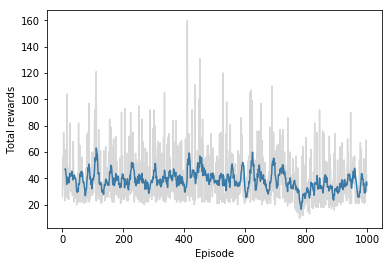

In [36]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Average losses')

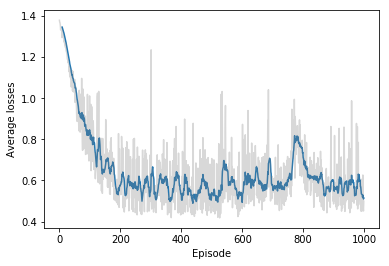

In [37]:
eps, arr = np.array(loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Average losses')

## Testing

Let's checkout how our trained agent plays the game.

In [5]:
import gym

# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:

    # Initialize/restore/load the trained model 
    #sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for each_episode in range(1):

        # Start a new episode/epoch
        state = env.reset()
        
        # Rendering the env graphics
        env.render()

        # Steps/batches
        for each_step in range(111111111111111111):
                        
            # Calculating next action using OLD memory
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            state, _, done, _ = env.step(action)
            #reward = 1 - float(done)
            if done:
                break
                
# Closing the env
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


NameError: name 'saver' is not defined

## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.